In [84]:
%load_ext autoreload
%autoreload 2
import os
import sys
import shutil
import argparse
import time
import json
from datetime import datetime
from collections import defaultdict
from itertools import islice
import pickle
import copy
import numpy as np
import cv2
from easydict import EasyDict
from IPython.core.debugger import set_trace
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import autograd
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.nn.parallel import DistributedDataParallel
from tensorboardX import SummaryWriter

from mvn.models.triangulation import RANSACTriangulationNet, AlgebraicTriangulationNet, VolumetricTriangulationNet
from mvn.models.volumetric_temporal import VolumetricTemporalNet,\
                                           VolumetricTemporalAdaINNet,\
                                           VolumetricFRAdaINNet
from mvn.models.v2v import AdaIN, V2VModel, Basic3DBlock, Res3DBlock, Upsample3DBlock, Pool3DBlock, EncoderDecorder
from mvn.models.loss import KeypointsMSELoss, KeypointsMSESmoothLoss, KeypointsMAELoss, KeypointsL2Loss, VolumetricCELoss
from mvn.utils import img, multiview, op, vis, misc, cfg
from mvn.datasets.human36m import Human36MSingleViewDataset, Human36MMultiViewDataset
from mvn.datasets import utils as dataset_utils


def get_n(m):
    s = 0
    for param in m.parameters():
        s+=param.nelement()
    print (m.__class__, s//1024)    

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# V2V

In [80]:

CHANNELS_LIST_v2 = [128,128,  128,128,\
                    32,32,32,  128,128,  32,32,32, 128,128,  64,64,64,  128,128,\
                    128,128,  128,128,  128,128,  256,256,256,  256,256,\
                    128,128,128,  128,  128,128,  128,  64,64,64,  64,  32,32,32,  32,  32,32,  32,\
                    32,32] # 32,32

V2V_CHANNELS_LIST = [256, 32, 32, 32, 32, 32, 32, 32, 32, 32, 64, 64, 64, 64, 64, 128, 128, 128, 128, 128,\
                                  128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128,\
                                  128, 128, 128, 128, 128, 64, 64, 64, 32, 32, 32, 32, 32]


In [5]:
class V2VModel_configured(nn.Module):
    def __init__(self, config):
            super().__init__()
            input_channels = config.input_channels
            output_channels = config.output_channels
            normalization_type= config.normalization_type

            self.front_layer1 = Basic3DBlock(input_channels, 32, 7, normalization_type)
            self.front_layer2 = Res3DBlock(32, 32, normalization_type)
            self.front_layer3 = Res3DBlock(32, 32, normalization_type)
            self.front_layer4 = Res3DBlock(32, 32, normalization_type)
            # [32, 32,32, 32,32, 32,32]

            self.encoder_decoder = EncoderDecorder_configured(normalization_type)
            # [32,32, 64,64,64, 64,64, 128,128,128, 128,128, 128,128,
            # 128,128, 128,128, 128,128, 128,128, 128,128, 128,128, 128,
            # 128,128, 128, 128,128, 128, 128,128, 64, 64,64, 32]

            self.back_layer1 = Res3DBlock(32, 32, normalization_type)
            self.back_layer2 = Basic3DBlock(32, 32, 1, normalization_type)
            self.back_layer3 = Basic3DBlock(32, 32, 1, normalization_type)
            # [32,32, 32, 32]

            self.output_layer = nn.Conv3d(32, output_channels, kernel_size=1, stride=1, padding=0)

            self._initialize_weights()

# Seq2VecCNN

In [81]:
class Slice(nn.Module):
    def __init__(self, shift):
        super(Slice, self).__init__()
        self.shift = shift
    def forward(self,x):
        return x[:, :, self.shift : x.shape[2] - self.shift]

class Res1DBlock(nn.Module):
    def __init__(self, in_planes, out_planes, n_groups = 32, kernel_size=3):
        
        super(Res1DBlock, self).__init__()
        pad = kernel_size // 2 if kernel_size > 1 else 0
        self.res_branch = nn.Sequential(
            nn.Conv1d(in_planes, out_planes, kernel_size=kernel_size, padding=pad),
            nn.GroupNorm(n_groups, out_planes),
            nn.ReLU(True),
            nn.Conv1d(out_planes, out_planes, kernel_size=kernel_size),
            nn.GroupNorm(n_groups, out_planes)
        )

        if in_planes == out_planes:
            self.skip_con = Slice(kernel_size // 2)
        else:
            self.skip_con = nn.Sequential(
                Slice(kernel_size // 2),
                nn.Conv1d(in_planes, out_planes, kernel_size=1),
                nn.GroupNorm(n_groups, out_planes)
            )

    def forward(self, x):
        res = self.res_branch(x)
        skip = self.skip_con(x)
        print (x.shape, skip.shape)
        return F.relu(res + skip, True)

In [82]:

class Seq2VecCNN(nn.Module):
    """docstring for Seq2VecCNN"""
    def __init__(self, 
                 input_features_dim, 
                 output_features_dim=1024, 
                 intermediate_channels=512, 
                 dt = 8,
                 kernel_size = 3):
        
        super(Seq2VecCNN, self).__init__()
        self.input_features_dim = input_features_dim
        self.output_features_dim = output_features_dim
        self.intermediate_channels = intermediate_channels
        
        self.first_block = Res1DBlock(input_features_dim, 
                                      intermediate_channels,
                                      kernel_size=1)
        
        
        l = dt
        blocks =  []
        while True:
            l = l - kernel_size + 1
            if l < kernel_size:
                break
            print (l)    
            blocks.append(Res1DBlock(intermediate_channels, 
                                     intermediate_channels, 
                                     kernel_size = kernel_size))
        
        self.blocks = nn.Sequential(*blocks)    
        self.final_block = nn.Conv1d(intermediate_channels, 
                                      output_features_dim,
                                      kernel_size=l)
        
    def forward(self, x, device='cuda:0'):
        # [batch_size, dt, feature_shape]
        x = x.transpose(1,2) # [batch_size, dt, feature_shape] -> [batch_size, feature_shape, dt]
        x  = self.first_block(x)
        x  = self.blocks(x)
        print (x.shape)
        x  = self.final_block(x)
        
        return x[...,0]

In [83]:
dt = 7
model = Seq2VecCNN(128, dt = dt, kernel_size=3)
model(torch.randn(4,dt,128)).shape

5
3
torch.Size([4, 128, 7]) torch.Size([4, 512, 7])
torch.Size([4, 512, 7]) torch.Size([4, 512, 5])
torch.Size([4, 512, 5]) torch.Size([4, 512, 3])
torch.Size([4, 512, 3])


torch.Size([4, 1024])

# AdaIN

In [2]:
adain = AdaIN()

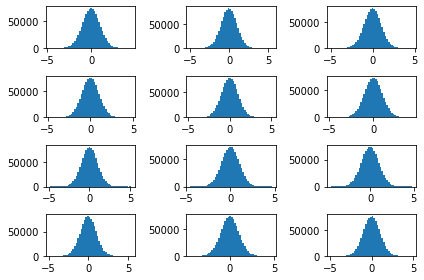

after adain


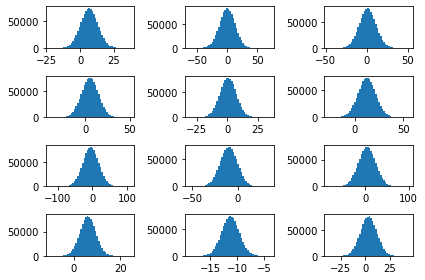

In [14]:
batch_size, C, N = 4,3,100
x = torch.randn(batch_size, C, N,N,N)
s = torch.randn(batch_size, 2*C)*10

fig, axes = plt.subplots(nrows=batch_size,ncols=C)
for i in range(batch_size):
    for j in range(C):
        axes[i][j].hist(x[i,j].data.flatten().numpy(), bins=50)
        
plt.tight_layout()
plt.show() 

y = adain(x,s)
print('after adain')
fig, axes = plt.subplots(nrows=batch_size,ncols=C)
for i in range(batch_size):
    for j in range(C):
        axes[i][j].hist(y[i,j].data.flatten().numpy(),bins=50)
        
plt.tight_layout()
plt.show() 

# Features Encoder\Decoder

In [44]:
from torchvision import models
class FeaturesEncoder_ResNet(nn.Module):
    """docstring for FeaturesEncoder"""
    def __init__(self, input_features_dim, output_features_dim, pretrained=False):
        super().__init__()
        self.input_features_dim = input_features_dim
        self.output_features_dim = output_features_dim
        self.pretrained = pretrained
                
        self.features = nn.Sequential(nn.Conv2d(self.input_features_dim,128,3),
                               nn.BatchNorm2d(128),
                               nn.ReLU(),
                               nn.MaxPool2d(2),
                               nn.Conv2d(128,64,3),
                               nn.BatchNorm2d(64),
                               nn.ReLU(),
                               nn.MaxPool2d(2),
                               nn.Conv2d(64,32,1),
                               nn.BatchNorm2d(32),
                               nn.ReLU(),
                               nn.MaxPool2d(2),
                               nn.Conv2d(32,16,1),
                               nn.BatchNorm2d(16),
                               nn.ReLU(),
                               nn.MaxPool2d(2))
        
    def forward(self, x):
        x = self.features(x)
        return x
    
    

    
    
class FeaturesEncoder_Bottleneck(nn.Module):
    """docstring for FeaturesEncoder_Bottleneck"""
    def __init__(self, output_features_dim, C = 4, multiplier=128):
        super().__init__()
        self.output_features_dim = output_features_dim
        self.C = C
        self.multiplier = multiplier
        self.features=nn.Sequential(nn.Conv2d(2048, 
                                              self.C * self.multiplier, 
                                              kernel_size=3, 
                                              stride=2),
                                      nn.BatchNorm2d(self.C * self.multiplier),
                                      nn.ReLU(),
                                      nn.Conv2d(self.C * self.multiplier, 
                                                self.C * self.multiplier//2, 
                                                kernel_size=3, 
                                                stride=1),
                                      nn.BatchNorm2d(self.C * self.multiplier//2),
                                      nn.ReLU(),
                                      nn.Conv2d(self.C * self.multiplier//2,
                                                self.C * self.multiplier//4, 
                                                kernel_size=3, 
                                                stride=1),
                                      nn.BatchNorm2d(self.C * self.multiplier//4),
                                      nn.ReLU(),
                                      nn.Conv2d(self.C * self.multiplier//4,
                                                self.C * self.multiplier//4, kernel_size=1),
                                      nn.BatchNorm2d(self.C * self.multiplier//4),
                                      nn.ReLU()
                                    )
        
        self.linear = nn.Linear(self.C * self.multiplier//4, output_features_dim)
        self.activation = nn.ReLU()
        
    def forward(self, x):
        batch_size = x.shape[0]
        x = self.features(x)
        x = x.view(batch_size, -1)
        x = self.linear(x)
        x = self.activation(x)
        return x   

In [45]:
x = torch.randn(4,256,96,96)
m = FeaturesEncoder_DenseNet(256, 1024)
m(x).shape

/media/hpc2_storage/ibulygin/miniconda3/envs/mvn/lib/python3.6/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


torch.Size([4, 1024])

# Backbone

In [73]:
from mvn.models.pose_resnet import get_pose_net
config = cfg.load_config('./experiments/human36m/train/human36m_vol_temporal_softmax_lstm_adain.yaml')
pose_resnet = get_pose_net(config.model.backbone, device='cpu')

Loading pretrained weights from: ./data/pose_resnet_4.5_pixels_human36m.pth
Parameters [{'final_layer.weight', 'final_layer.bias'}] were not inited
Successfully loaded pretrained weights for backbone


In [77]:
heatmaps, features, alg_confidences, vol_confidences, bottleneck = pose_resnet.forward(torch.randn(4,3,384,384))

In [78]:
bottleneck.shape

torch.Size([4, 2048, 12, 12])

In [158]:
m = FeaturesEncoder_Bottleneck(1024)

In [159]:
m(bottleneck).shape

torch.Size([4, 1024])

# Seq2Vec

In [171]:
class Seq2VecRNN(nn.Module):
    """docstring for Seq2VecRNN"""
    def __init__(self, input_features_dim, output_features_dim=1024, hidden_dim = 1024):
        super(Seq2VecRNN, self).__init__()
        self.input_features_dim = input_features_dim
        self.output_features_dim = output_features_dim
        self.hidden_dim = hidden_dim
        
        self.lstm = nn.LSTM(self.input_features_dim, self.hidden_dim, batch_first=True)
        
        if self.output_features_dim != self.hidden_dim :
            self.output_layer = nn.Linear(self.hidden_dim, self.output_features_dim)
            self.activation = nn.ReLU()
        
    def forward(self, features, eps = 1e-3, device='cuda:0'):
        # [bathc_size, dt, feature_shape]
        batch_size = features.shape[0]
        (h0, c0) = torch.randn(1, batch_size, self.hidden_dim, device=device)*eps,\
                   torch.randn(1, batch_size, self.hidden_dim, device=device)*eps
        output, (hn, cn) = self.lstm(features, (h0, c0))
        output = output[:,-1,...]
        if self.output_features_dim is not None:
            output = self.activation(self.output_layer(output))
        return output

In [172]:
seq2vec=Seq2VecRNN(1024,output_features_dim=512)

In [173]:
seq2vec.forward(torch.randn(10,8,1024), device='cpu').shape

torch.Size([10, 512])

# Recursive unprojecting

In [ ]:
batch_size = 10
dt = 

heatmaps = torch.randn()
proj_matricies 
coord_volumes 
volume_aggregation_method='sum'
vol_confidences=None, volumes_multipliers=1.
    
device = 'cpu'    
batch_size, n_views, n_joints, heatmap_shape = heatmaps.shape[0], heatmaps.shape[1], heatmaps.shape[2], tuple(heatmaps.shape[3:])
volume_shape = coord_volumes.shape[1:4]

volume_batch = [] if volume_aggregation_method=='no_aggregation' else torch.zeros(batch_size, n_joints, *volume_shape, device=device)

# TODO: speed up this this loop
for batch_i in range(batch_size):
    coord_volume = coord_volumes[batch_i]
    grid_coord = coord_volume.reshape((-1, 3))

    volume_batch_to_aggregate = torch.zeros(n_views, n_joints, *volume_shape, device=device)

    for view_i in range(n_views):
        heatmap = heatmaps[batch_i, view_i]
        heatmap = heatmap.unsqueeze(0)

        grid_coord_proj = multiview.project_3d_points_to_image_plane_without_distortion(
            proj_matricies[batch_i, view_i], grid_coord, convert_back_to_euclidean=False
        )

        invalid_mask = grid_coord_proj[:, 2] <= 0.0  # depth must be larger than 0.0

        grid_coord_proj[grid_coord_proj[:, 2] == 0.0, 2] = 1.0  # not to divide by zero
        grid_coord_proj = multiview.homogeneous_to_euclidean(grid_coord_proj)

        # transform to [-1.0, 1.0] range
        grid_coord_proj_transformed = torch.zeros_like(grid_coord_proj)
        grid_coord_proj_transformed[:, 0] = 2 * (grid_coord_proj[:, 0] / heatmap_shape[0] - 0.5)
        grid_coord_proj_transformed[:, 1] = 2 * (grid_coord_proj[:, 1] / heatmap_shape[1] - 0.5)
        grid_coord_proj = grid_coord_proj_transformed

        # prepare to F.grid_sample
        grid_coord_proj = grid_coord_proj.unsqueeze(1).unsqueeze(0)
        current_volume = F.grid_sample(heatmap, grid_coord_proj)

        # zero out non-valid points
        current_volume = current_volume.view(n_joints, -1)
        current_volume[:, invalid_mask] = 0.0

        # reshape back to volume
        current_volume = current_volume.view(n_joints, *volume_shape)

        # collect
        volume_batch_to_aggregate[view_i] = current_volume

    # agregate resulting volume
    if volume_aggregation_method.startswith('conf'):
        volume_batch[batch_i] = (volume_batch_to_aggregate * vol_confidences[batch_i].view(n_views, n_joints, 1, 1, 1)).sum(0)
    elif volume_aggregation_method == 'sum':
        volume_batch[batch_i] = volume_batch_to_aggregate.sum(0)
    elif volume_aggregation_method == 'max':
        volume_batch[batch_i] = volume_batch_to_aggregate.max(0)[0]
    elif volume_aggregation_method == 'softmax':
        volume_batch_to_aggregate_softmin = volume_batch_to_aggregate.clone()
        volume_batch_to_aggregate_softmin = volume_batch_to_aggregate_softmin.view(n_views, -1)
        volume_batch_to_aggregate_softmin = nn.functional.softmax(volume_batch_to_aggregate_softmin, dim=0)
        volume_batch_to_aggregate_softmin = volume_batch_to_aggregate_softmin.view(n_views, n_joints, *volume_shape)

        volume_batch[batch_i] = (volume_batch_to_aggregate * volume_batch_to_aggregate_softmin).sum(0)

    elif volume_aggregation_method == 'no_aggregation':
        volume_batch.append(volume_batch_to_aggregate*volumes_multipliers[view_i])
    else:
        raise ValueError("Unknown volume_aggregation_method: {}".format(volume_aggregation_method))

return volume_batch